# Process plate counts to get fraction infectivities and fit curves
This notebook is designed to be run using `snakemake`, and analyzes a plate of sequencing-based neutralization assays.

## Setup
Import Python modules:

In [1]:
import altair as alt

import neutcurve

import pandas as pd

_ = alt.data_transformers.disable_max_rows()

Get the variables passed by `snakemake`:

In [2]:

######## snakemake preamble start (automatically inserted, do not edit) ########
import sys; sys.path.extend(['/fh/fast/bloom_j/software/miniconda3/envs/seqneut-pipeline/lib/python3.11/site-packages', '/fh/fast/bloom_j/computational_notebooks/jbloom/2023/flu_seqneut_DRIVE_2021-22_repeat_vax/seqneut-pipeline', '/fh/fast/bloom_j/computational_notebooks/jbloom/2023/flu_seqneut_DRIVE_2021-22_repeat_vax/seqneut-pipeline/test_example/..', '/fh/fast/bloom_j/computational_notebooks/jbloom/2023/flu_seqneut_DRIVE_2021-22_repeat_vax/seqneut-pipeline/test_example', '/fh/fast/bloom_j/software/miniconda3/envs/seqneut-pipeline/bin', '/fh/fast/bloom_j/software/miniconda3/envs/seqneut-pipeline/lib/python3.11', '/fh/fast/bloom_j/software/miniconda3/envs/seqneut-pipeline/lib/python3.11/lib-dynload', '/home/jbloom/.local/lib/python3.11/site-packages', '/fh/fast/bloom_j/software/miniconda3/envs/seqneut-pipeline/lib/python3.11/site-packages', '/home/jbloom/.cache/snakemake/snakemake/source-cache/runtime-cache/tmp8en2sdjp/file/fh/fast/bloom_j/computational_notebooks/jbloom/2023/flu_seqneut_DRIVE_2021-22_repeat_vax/seqneut-pipeline/notebooks', '/fh/fast/bloom_j/computational_notebooks/jbloom/2023/flu_seqneut_DRIVE_2021-22_repeat_vax/seqneut-pipeline/notebooks']); import pickle; snakemake = pickle.loads(b'\x80\x04\x9574\x00\x00\x00\x00\x00\x00\x8c\x10snakemake.script\x94\x8c\tSnakemake\x94\x93\x94)\x81\x94}\x94(\x8c\x05input\x94\x8c\x0csnakemake.io\x94\x8c\nInputFiles\x94\x93\x94)\x81\x94(\x8c(results/barcode_counts/plate2_none-9.csv\x94\x8c,results/barcode_counts/plate2_M099d30_20.csv\x94\x8c,results/barcode_counts/plate2_M099d30_60.csv\x94\x8c-results/barcode_counts/plate2_M099d30_180.csv\x94\x8c-results/barcode_counts/plate2_M099d30_540.csv\x94\x8c.results/barcode_counts/plate2_M099d30_1620.csv\x94\x8c.results/barcode_counts/plate2_M099d30_4860.csv\x94\x8c/results/barcode_counts/plate2_M099d30_14580.csv\x94\x8c/results/barcode_counts/plate2_M099d30_43740.csv\x94\x8c0results/barcode_counts/plate2_M099d30_131220.csv\x94\x8c0results/barcode_counts/plate2_M099d30_393660.csv\x94\x8c(results/barcode_counts/plate2_none-2.csv\x94\x8c)results/barcode_counts/plate2_none-10.csv\x94\x8c+results/barcode_counts/plate2_M099d0_20.csv\x94\x8c+results/barcode_counts/plate2_M099d0_60.csv\x94\x8c,results/barcode_counts/plate2_M099d0_180.csv\x94\x8c,results/barcode_counts/plate2_M099d0_540.csv\x94\x8c-results/barcode_counts/plate2_M099d0_1620.csv\x94\x8c-results/barcode_counts/plate2_M099d0_4860.csv\x94\x8c.results/barcode_counts/plate2_M099d0_14580.csv\x94\x8c.results/barcode_counts/plate2_M099d0_43740.csv\x94\x8c/results/barcode_counts/plate2_M099d0_131220.csv\x94\x8c/results/barcode_counts/plate2_M099d0_393660.csv\x94\x8c(results/barcode_counts/plate2_none-3.csv\x94\x8c)results/barcode_counts/plate2_none-11.csv\x94\x8c-results/barcode_counts/plate2_Y154d182_20.csv\x94\x8c-results/barcode_counts/plate2_Y154d182_60.csv\x94\x8c.results/barcode_counts/plate2_Y154d182_180.csv\x94\x8c.results/barcode_counts/plate2_Y154d182_540.csv\x94\x8c/results/barcode_counts/plate2_Y154d182_1620.csv\x94\x8c/results/barcode_counts/plate2_Y154d182_4860.csv\x94\x8c0results/barcode_counts/plate2_Y154d182_14580.csv\x94\x8c0results/barcode_counts/plate2_Y154d182_43740.csv\x94\x8c1results/barcode_counts/plate2_Y154d182_131220.csv\x94\x8c1results/barcode_counts/plate2_Y154d182_393660.csv\x94\x8c(results/barcode_counts/plate2_none-4.csv\x94\x8c\'results/barcode_fates/plate2_none-9.csv\x94\x8c+results/barcode_fates/plate2_M099d30_20.csv\x94\x8c+results/barcode_fates/plate2_M099d30_60.csv\x94\x8c,results/barcode_fates/plate2_M099d30_180.csv\x94\x8c,results/barcode_fates/plate2_M099d30_540.csv\x94\x8c-results/barcode_fates/plate2_M099d30_1620.csv\x94\x8c-results/barcode_fates/plate2_M099d30_4860.csv\x94\x8c.results/barcode_fates/plate2_M099d30_14580.csv\x94\x8c.results/barcode_fates/plate2_M099d30_43740.csv\x94\x8c/results/barcode_fates/plate2_M099d30_131220.csv\x94\x8c/results/barcode_fates/plate2_M099d30_393660.csv\x94\x8c\'results/barcode_fates/plate2_none-2.csv\x94\x8c(results/barcode_fates/plate2_none-10.csv\x94\x8c*results/barcode_fates/plate2_M099d0_20.csv\x94\x8c*results/barcode_fates/plate2_M099d0_60.csv\x94\x8c+results/barcode_fates/plate2_M099d0_180.csv\x94\x8c+results/barcode_fates/plate2_M099d0_540.csv\x94\x8c,results/barcode_fates/plate2_M099d0_1620.csv\x94\x8c,results/barcode_fates/plate2_M099d0_4860.csv\x94\x8c-results/barcode_fates/plate2_M099d0_14580.csv\x94\x8c-results/barcode_fates/plate2_M099d0_43740.csv\x94\x8c.results/barcode_fates/plate2_M099d0_131220.csv\x94\x8c.results/barcode_fates/plate2_M099d0_393660.csv\x94\x8c\'results/barcode_fates/plate2_none-3.csv\x94\x8c(results/barcode_fates/plate2_none-11.csv\x94\x8c,results/barcode_fates/plate2_Y154d182_20.csv\x94\x8c,results/barcode_fates/plate2_Y154d182_60.csv\x94\x8c-results/barcode_fates/plate2_Y154d182_180.csv\x94\x8c-results/barcode_fates/plate2_Y154d182_540.csv\x94\x8c.results/barcode_fates/plate2_Y154d182_1620.csv\x94\x8c.results/barcode_fates/plate2_Y154d182_4860.csv\x94\x8c/results/barcode_fates/plate2_Y154d182_14580.csv\x94\x8c/results/barcode_fates/plate2_Y154d182_43740.csv\x94\x8c0results/barcode_fates/plate2_Y154d182_131220.csv\x94\x8c0results/barcode_fates/plate2_Y154d182_393660.csv\x94\x8c\'results/barcode_fates/plate2_none-4.csv\x94\x8c-data/viral_libraries/pdmH1N1_lib2023_loes.csv\x94\x8c3data/neut_standard_sets/loes2023_neut_standards.csv\x94e}\x94(\x8c\x06_names\x94}\x94(\x8c\ncount_csvs\x94K\x00K$\x86\x94\x8c\tfate_csvs\x94K$KH\x86\x94\x8c\x11viral_library_csv\x94KHN\x86\x94\x8c\x15neut_standard_set_csv\x94KIN\x86\x94u\x8c\x12_allowed_overrides\x94]\x94(\x8c\x05index\x94\x8c\x04sort\x94eha\x8c\tfunctools\x94\x8c\x07partial\x94\x93\x94h\x06\x8c\x19Namedlist._used_attribute\x94\x93\x94\x85\x94R\x94(hg)}\x94\x8c\x05_name\x94hasNt\x94bhbhehg\x85\x94R\x94(hg)}\x94hkhbsNt\x94bhWh\x06\x8c\tNamedlist\x94\x93\x94)\x81\x94(h\nh\x0bh\x0ch\rh\x0eh\x0fh\x10h\x11h\x12h\x13h\x14h\x15h\x16h\x17h\x18h\x19h\x1ah\x1bh\x1ch\x1dh\x1eh\x1fh h!h"h#h$h%h&h\'h(h)h*h+h,h-e}\x94(hU}\x94h_]\x94(hahbehahehg\x85\x94R\x94(hg)}\x94hkhasNt\x94bhbhehg\x85\x94R\x94(hg)}\x94hkhbsNt\x94bubhYhr)\x81\x94(h.h/h0h1h2h3h4h5h6h7h8h9h:h;h<h=h>h?h@hAhBhChDhEhFhGhHhIhJhKhLhMhNhOhPhQe}\x94(hU}\x94h_]\x94(hahbehahehg\x85\x94R\x94(hg)}\x94hkhasNt\x94bhbhehg\x85\x94R\x94(hg)}\x94hkhbsNt\x94bubh[hRh]hSub\x8c\x06output\x94h\x06\x8c\x0bOutputFiles\x94\x93\x94)\x81\x94(\x8c4results/plates/plate2/process_counts_qc_failures.txt\x94\x8c*results/plates/plate2/frac_infectivity.csv\x94e}\x94(hU}\x94(\x8c\x0bqc_failures\x94K\x00N\x86\x94\x8c\x14frac_infectivity_csv\x94K\x01N\x86\x94uh_]\x94(hahbehahehg\x85\x94R\x94(hg)}\x94hkhasNt\x94bhbhehg\x85\x94R\x94(hg)}\x94hkhbsNt\x94bh\x93h\x8fh\x95h\x90ub\x8c\x06params\x94h\x06\x8c\x06Params\x94\x93\x94)\x81\x94(]\x94(\x8c\rplate2_none-9\x94\x8c\x11plate2_M099d30_20\x94\x8c\x11plate2_M099d30_60\x94\x8c\x12plate2_M099d30_180\x94\x8c\x12plate2_M099d30_540\x94\x8c\x13plate2_M099d30_1620\x94\x8c\x13plate2_M099d30_4860\x94\x8c\x14plate2_M099d30_14580\x94\x8c\x14plate2_M099d30_43740\x94\x8c\x15plate2_M099d30_131220\x94\x8c\x15plate2_M099d30_393660\x94\x8c\rplate2_none-2\x94\x8c\x0eplate2_none-10\x94\x8c\x10plate2_M099d0_20\x94\x8c\x10plate2_M099d0_60\x94\x8c\x11plate2_M099d0_180\x94\x8c\x11plate2_M099d0_540\x94\x8c\x12plate2_M099d0_1620\x94\x8c\x12plate2_M099d0_4860\x94\x8c\x13plate2_M099d0_14580\x94\x8c\x13plate2_M099d0_43740\x94\x8c\x14plate2_M099d0_131220\x94\x8c\x14plate2_M099d0_393660\x94\x8c\rplate2_none-3\x94\x8c\x0eplate2_none-11\x94\x8c\x12plate2_Y154d182_20\x94\x8c\x12plate2_Y154d182_60\x94\x8c\x13plate2_Y154d182_180\x94\x8c\x13plate2_Y154d182_540\x94\x8c\x14plate2_Y154d182_1620\x94\x8c\x14plate2_Y154d182_4860\x94\x8c\x15plate2_Y154d182_14580\x94\x8c\x15plate2_Y154d182_43740\x94\x8c\x16plate2_Y154d182_131220\x94\x8c\x16plate2_Y154d182_393660\x94\x8c\rplate2_none-4\x94e}\x94(\x8c\x04date\x94\x8c\n2023-08-01\x94\x8c\rviral_library\x94\x8c\x14pdmH1N1_lib2023_loes\x94\x8c\x11neut_standard_set\x94\x8c\x08loes2023\x94\x8c\x0bsamples_csv\x94\x8c\x1edata/plates/plate2_samples.csv\x94\x8c\x1cprocess_counts_qc_thresholds\x94}\x94(\x8c\x12avg_barcode_counts\x94K\xfa\x8c\x16min_neut_standard_frac\x94G?tz\xe1G\xae\x14{\x8c\x1fmax_neut_standard_frac_no_serum\x94G?\xb9\x99\x99\x99\x99\x99\x9a\x8c\x18barcode_frac_consistency\x94K\x04\x8c\x16min_viral_barcode_frac\x94G?@bM\xd2\xf1\xa9\xfc\x8c\x1emin_neut_standard_barcode_frac\x94G?tz\xe1G\xae\x14{\x8c\x17min_neut_standard_count\x94M^\x01\x8c min_no_serum_viral_barcode_count\x94K\x05\x8c!min_dilutions_per_serum_replicate\x94K\x04\x8c\x14max_frac_infectivity\x94K\x08u\x8c\x10barcodes_to_drop\x94]\x94\x8c\x10GGTCCATCTCAGATCG\x94a\x8c\rwells_to_drop\x94]\x94(\x8c\x02C1\x94\x8c\x03D12\x94e\x8c\x07samples\x94}\x94(\x8c\x04well\x94}\x94(K\x00\x8c\x02B1\x94K\x01\x8c\x02B2\x94K\x02\x8c\x02B3\x94K\x03\x8c\x02B4\x94K\x04\x8c\x02B5\x94K\x05\x8c\x02B6\x94K\x06\x8c\x02B7\x94K\x07\x8c\x02B8\x94K\x08\x8c\x02B9\x94K\t\x8c\x03B10\x94K\n\x8c\x03B11\x94K\x0b\x8c\x03B12\x94K\x0c\x8c\x02C1\x94K\r\x8c\x02C2\x94K\x0e\x8c\x02C3\x94K\x0f\x8c\x02C4\x94K\x10\x8c\x02C5\x94K\x11\x8c\x02C6\x94K\x12\x8c\x02C7\x94K\x13\x8c\x02C8\x94K\x14\x8c\x02C9\x94K\x15\x8c\x03C10\x94K\x16\x8c\x03C11\x94K\x17\x8c\x03C12\x94K\x18\x8c\x02D1\x94K\x19\x8c\x02D2\x94K\x1a\x8c\x02D3\x94K\x1b\x8c\x02D4\x94K\x1c\x8c\x02D5\x94K\x1d\x8c\x02D6\x94K\x1e\x8c\x02D7\x94K\x1f\x8c\x02D8\x94K \x8c\x02D9\x94K!\x8c\x03D10\x94K"\x8c\x03D11\x94K#\x8c\x03D12\x94u\x8c\x05serum\x94}\x94(K\x00\x8c\x04none\x94K\x01\x8c\x07M099d30\x94K\x02j\x10\x01\x00\x00K\x03j\x10\x01\x00\x00K\x04j\x10\x01\x00\x00K\x05j\x10\x01\x00\x00K\x06j\x10\x01\x00\x00K\x07j\x10\x01\x00\x00K\x08j\x10\x01\x00\x00K\tj\x10\x01\x00\x00K\nj\x10\x01\x00\x00K\x0bj\x0f\x01\x00\x00K\x0cj\x0f\x01\x00\x00K\r\x8c\x06M099d0\x94K\x0ej\x11\x01\x00\x00K\x0fj\x11\x01\x00\x00K\x10j\x11\x01\x00\x00K\x11j\x11\x01\x00\x00K\x12j\x11\x01\x00\x00K\x13j\x11\x01\x00\x00K\x14j\x11\x01\x00\x00K\x15j\x11\x01\x00\x00K\x16j\x11\x01\x00\x00K\x17j\x0f\x01\x00\x00K\x18j\x0f\x01\x00\x00K\x19\x8c\x08Y154d182\x94K\x1aj\x12\x01\x00\x00K\x1bj\x12\x01\x00\x00K\x1cj\x12\x01\x00\x00K\x1dj\x12\x01\x00\x00K\x1ej\x12\x01\x00\x00K\x1fj\x12\x01\x00\x00K j\x12\x01\x00\x00K!j\x12\x01\x00\x00K"j\x12\x01\x00\x00K#j\x0f\x01\x00\x00u\x8c\x0fdilution_factor\x94}\x94(K\x00NK\x01K\x14K\x02K<K\x03K\xb4K\x04M\x1c\x02K\x05MT\x06K\x06M\xfc\x12K\x07M\xf48K\x08M\xdc\xaaK\tJ\x94\x00\x02\x00K\nJ\xbc\x01\x06\x00K\x0bNK\x0cNK\rK\x14K\x0eK<K\x0fK\xb4K\x10M\x1c\x02K\x11MT\x06K\x12M\xfc\x12K\x13M\xf48K\x14M\xdc\xaaK\x15J\x94\x00\x02\x00K\x16J\xbc\x01\x06\x00K\x17NK\x18NK\x19K\x14K\x1aK<K\x1bK\xb4K\x1cM\x1c\x02K\x1dMT\x06K\x1eM\xfc\x12K\x1fM\xf48K M\xdc\xaaK!J\x94\x00\x02\x00K"J\xbc\x01\x06\x00K#Nu\x8c\treplicate\x94}\x94(K\x00K\tK\x01K\x01K\x02K\x01K\x03K\x01K\x04K\x01K\x05K\x01K\x06K\x01K\x07K\x01K\x08K\x01K\tK\x01K\nK\x01K\x0bK\x02K\x0cK\nK\rK\x01K\x0eK\x01K\x0fK\x01K\x10K\x01K\x11K\x01K\x12K\x01K\x13K\x01K\x14K\x01K\x15K\x01K\x16K\x01K\x17K\x03K\x18K\x0bK\x19K\x01K\x1aK\x01K\x1bK\x01K\x1cK\x01K\x1dK\x01K\x1eK\x01K\x1fK\x01K K\x01K!K\x01K"K\x01K#K\x04u\x8c\x05fastq\x94}\x94(K\x00\x8c*fastqs/Plate2_Noserum2_S98_R1_001.fastq.gz\x94K\x01\x8c*fastqs/M099_d30_conc1_S106_R1_001.fastq.gz\x94K\x02\x8c*fastqs/M099_d30_conc2_S114_R1_001.fastq.gz\x94K\x03\x8c*fastqs/M099_d30_conc3_S122_R1_001.fastq.gz\x94K\x04\x8c*fastqs/M099_d30_conc4_S130_R1_001.fastq.gz\x94K\x05\x8c*fastqs/M099_d30_conc5_S138_R1_001.fastq.gz\x94K\x06\x8c*fastqs/M099_d30_conc6_S146_R1_001.fastq.gz\x94K\x07\x8c*fastqs/M099_d30_conc7_S154_R1_001.fastq.gz\x94K\x08\x8c*fastqs/M099_d30_conc8_S162_R1_001.fastq.gz\x94K\t\x8c*fastqs/M099_d30_conc9_S170_R1_001.fastq.gz\x94K\n\x8c+fastqs/M099_d30_conc10_S178_R1_001.fastq.gz\x94K\x0b\x8c,fastqs/Plate2_Noserum10_S186_R1_001.fastq.gz\x94K\x0c\x8c*fastqs/Plate2_Noserum3_S99_R1_001.fastq.gz\x94K\r\x8c)fastqs/M099_d0_conc1_S107_R1_001.fastq.gz\x94K\x0e\x8c)fastqs/M099_d0_conc2_S115_R1_001.fastq.gz\x94K\x0f\x8c)fastqs/M099_d0_conc3_S123_R1_001.fastq.gz\x94K\x10\x8c)fastqs/M099_d0_conc4_S131_R1_001.fastq.gz\x94K\x11\x8c)fastqs/M099_d0_conc5_S139_R1_001.fastq.gz\x94K\x12\x8c)fastqs/M099_d0_conc6_S147_R1_001.fastq.gz\x94K\x13\x8c)fastqs/M099_d0_conc7_S155_R1_001.fastq.gz\x94K\x14\x8c)fastqs/M099_d0_conc8_S163_R1_001.fastq.gz\x94K\x15\x8c)fastqs/M099_d0_conc9_S171_R1_001.fastq.gz\x94K\x16\x8c*fastqs/M099_d0_conc10_S179_R1_001.fastq.gz\x94K\x17\x8c,fastqs/Plate2_Noserum11_S187_R1_001.fastq.gz\x94K\x18\x8c+fastqs/Plate2_Noserum4_S100_R1_001.fastq.gz\x94K\x19\x8c+fastqs/Y154_d182_conc1_S108_R1_001.fastq.gz\x94K\x1a\x8c+fastqs/Y154_d182_conc2_S116_R1_001.fastq.gz\x94K\x1b\x8c+fastqs/Y154_d182_conc3_S124_R1_001.fastq.gz\x94K\x1c\x8c+fastqs/Y154_d182_conc4_S132_R1_001.fastq.gz\x94K\x1d\x8c+fastqs/Y154_d182_conc5_S140_R1_001.fastq.gz\x94K\x1e\x8c+fastqs/Y154_d182_conc6_S148_R1_001.fastq.gz\x94K\x1f\x8c+fastqs/Y154_d182_conc7_S156_R1_001.fastq.gz\x94K \x8c+fastqs/Y154_d182_conc8_S164_R1_001.fastq.gz\x94K!\x8c+fastqs/Y154_d182_conc9_S172_R1_001.fastq.gz\x94K"\x8c,fastqs/Y154_d182_conc10_S180_R1_001.fastq.gz\x94K#\x8c,fastqs/Plate2_Noserum12_S188_R1_001.fastq.gz\x94u\x8c\x0fserum_replicate\x94}\x94(K\x00\x8c\x06none-9\x94K\x01j\x10\x01\x00\x00K\x02j\x10\x01\x00\x00K\x03j\x10\x01\x00\x00K\x04j\x10\x01\x00\x00K\x05j\x10\x01\x00\x00K\x06j\x10\x01\x00\x00K\x07j\x10\x01\x00\x00K\x08j\x10\x01\x00\x00K\tj\x10\x01\x00\x00K\nj\x10\x01\x00\x00K\x0b\x8c\x06none-2\x94K\x0c\x8c\x07none-10\x94K\rj\x11\x01\x00\x00K\x0ej\x11\x01\x00\x00K\x0fj\x11\x01\x00\x00K\x10j\x11\x01\x00\x00K\x11j\x11\x01\x00\x00K\x12j\x11\x01\x00\x00K\x13j\x11\x01\x00\x00K\x14j\x11\x01\x00\x00K\x15j\x11\x01\x00\x00K\x16j\x11\x01\x00\x00K\x17\x8c\x06none-3\x94K\x18\x8c\x07none-11\x94K\x19j\x12\x01\x00\x00K\x1aj\x12\x01\x00\x00K\x1bj\x12\x01\x00\x00K\x1cj\x12\x01\x00\x00K\x1dj\x12\x01\x00\x00K\x1ej\x12\x01\x00\x00K\x1fj\x12\x01\x00\x00K j\x12\x01\x00\x00K!j\x12\x01\x00\x00K"j\x12\x01\x00\x00K#\x8c\x06none-4\x94u\x8c\x0esample_noplate\x94}\x94(K\x00j?\x01\x00\x00K\x01\x8c\nM099d30_20\x94K\x02\x8c\nM099d30_60\x94K\x03\x8c\x0bM099d30_180\x94K\x04\x8c\x0bM099d30_540\x94K\x05\x8c\x0cM099d30_1620\x94K\x06\x8c\x0cM099d30_4860\x94K\x07\x8c\rM099d30_14580\x94K\x08\x8c\rM099d30_43740\x94K\t\x8c\x0eM099d30_131220\x94K\n\x8c\x0eM099d30_393660\x94K\x0bj@\x01\x00\x00K\x0cjA\x01\x00\x00K\r\x8c\tM099d0_20\x94K\x0e\x8c\tM099d0_60\x94K\x0f\x8c\nM099d0_180\x94K\x10\x8c\nM099d0_540\x94K\x11\x8c\x0bM099d0_1620\x94K\x12\x8c\x0bM099d0_4860\x94K\x13\x8c\x0cM099d0_14580\x94K\x14\x8c\x0cM099d0_43740\x94K\x15\x8c\rM099d0_131220\x94K\x16\x8c\rM099d0_393660\x94K\x17jB\x01\x00\x00K\x18jC\x01\x00\x00K\x19\x8c\x0bY154d182_20\x94K\x1a\x8c\x0bY154d182_60\x94K\x1b\x8c\x0cY154d182_180\x94K\x1c\x8c\x0cY154d182_540\x94K\x1d\x8c\rY154d182_1620\x94K\x1e\x8c\rY154d182_4860\x94K\x1f\x8c\x0eY154d182_14580\x94K \x8c\x0eY154d182_43740\x94K!\x8c\x0fY154d182_131220\x94K"\x8c\x0fY154d182_393660\x94K#jD\x01\x00\x00u\x8c\x06sample\x94}\x94(K\x00h\xa5K\x01h\xa6K\x02h\xa7K\x03h\xa8K\x04h\xa9K\x05h\xaaK\x06h\xabK\x07h\xacK\x08h\xadK\th\xaeK\nh\xafK\x0bh\xb0K\x0ch\xb1K\rh\xb2K\x0eh\xb3K\x0fh\xb4K\x10h\xb5K\x11h\xb6K\x12h\xb7K\x13h\xb8K\x14h\xb9K\x15h\xbaK\x16h\xbbK\x17h\xbcK\x18h\xbdK\x19h\xbeK\x1ah\xbfK\x1bh\xc0K\x1ch\xc1K\x1dh\xc2K\x1eh\xc3K\x1fh\xc4K h\xc5K!h\xc6K"h\xc7K#h\xc8u\x8c\x05plate\x94}\x94(K\x00\x8c\x06plate2\x94K\x01ji\x01\x00\x00K\x02ji\x01\x00\x00K\x03ji\x01\x00\x00K\x04ji\x01\x00\x00K\x05ji\x01\x00\x00K\x06ji\x01\x00\x00K\x07ji\x01\x00\x00K\x08ji\x01\x00\x00K\tji\x01\x00\x00K\nji\x01\x00\x00K\x0bji\x01\x00\x00K\x0cji\x01\x00\x00K\rji\x01\x00\x00K\x0eji\x01\x00\x00K\x0fji\x01\x00\x00K\x10ji\x01\x00\x00K\x11ji\x01\x00\x00K\x12ji\x01\x00\x00K\x13ji\x01\x00\x00K\x14ji\x01\x00\x00K\x15ji\x01\x00\x00K\x16ji\x01\x00\x00K\x17ji\x01\x00\x00K\x18ji\x01\x00\x00K\x19ji\x01\x00\x00K\x1aji\x01\x00\x00K\x1bji\x01\x00\x00K\x1cji\x01\x00\x00K\x1dji\x01\x00\x00K\x1eji\x01\x00\x00K\x1fji\x01\x00\x00K ji\x01\x00\x00K!ji\x01\x00\x00K"ji\x01\x00\x00K#ji\x01\x00\x00u\x8c\x0fplate_replicate\x94}\x94(K\x00\x8c\x08plate2-9\x94K\x01ji\x01\x00\x00K\x02ji\x01\x00\x00K\x03ji\x01\x00\x00K\x04ji\x01\x00\x00K\x05ji\x01\x00\x00K\x06ji\x01\x00\x00K\x07ji\x01\x00\x00K\x08ji\x01\x00\x00K\tji\x01\x00\x00K\nji\x01\x00\x00K\x0b\x8c\x08plate2-2\x94K\x0c\x8c\tplate2-10\x94K\rji\x01\x00\x00K\x0eji\x01\x00\x00K\x0fji\x01\x00\x00K\x10ji\x01\x00\x00K\x11ji\x01\x00\x00K\x12ji\x01\x00\x00K\x13ji\x01\x00\x00K\x14ji\x01\x00\x00K\x15ji\x01\x00\x00K\x16ji\x01\x00\x00K\x17\x8c\x08plate2-3\x94K\x18\x8c\tplate2-11\x94K\x19ji\x01\x00\x00K\x1aji\x01\x00\x00K\x1bji\x01\x00\x00K\x1cji\x01\x00\x00K\x1dji\x01\x00\x00K\x1eji\x01\x00\x00K\x1fji\x01\x00\x00K ji\x01\x00\x00K!ji\x01\x00\x00K"ji\x01\x00\x00K#\x8c\x08plate2-4\x94uuue}\x94(hU}\x94(h\xe5K\x00N\x86\x94\x8c\x0cplate_params\x94K\x01N\x86\x94uh_]\x94(hahbehahehg\x85\x94R\x94(hg)}\x94hkhasNt\x94bhbhehg\x85\x94R\x94(hg)}\x94hkhbsNt\x94bh\xe5h\xa4ju\x01\x00\x00h\xc9ub\x8c\twildcards\x94h\x06\x8c\tWildcards\x94\x93\x94)\x81\x94\x8c\x06plate2\x94a}\x94(hU}\x94\x8c\x05plate\x94K\x00N\x86\x94sh_]\x94(hahbehahehg\x85\x94R\x94(hg)}\x94hkhasNt\x94bhbhehg\x85\x94R\x94(hg)}\x94hkhbsNt\x94bjg\x01\x00\x00j\x84\x01\x00\x00ub\x8c\x07threads\x94K\x01\x8c\tresources\x94h\x06\x8c\tResources\x94\x93\x94)\x81\x94(K\x01K\x01\x8c\x04/tmp\x94e}\x94(hU}\x94(\x8c\x06_cores\x94K\x00N\x86\x94\x8c\x06_nodes\x94K\x01N\x86\x94\x8c\x06tmpdir\x94K\x02N\x86\x94uh_]\x94(hahbehahehg\x85\x94R\x94(hg)}\x94hkhasNt\x94bhbhehg\x85\x94R\x94(hg)}\x94hkhbsNt\x94bj\x9a\x01\x00\x00K\x01j\x9c\x01\x00\x00K\x01j\x9e\x01\x00\x00j\x97\x01\x00\x00ub\x8c\x03log\x94h\x06\x8c\x03Log\x94\x93\x94)\x81\x94\x8c1results/plates/plate2/process_counts_plate2.ipynb\x94a}\x94(hU}\x94\x8c\x08notebook\x94K\x00N\x86\x94sh_]\x94(hahbehahehg\x85\x94R\x94(hg)}\x94hkhasNt\x94bhbhehg\x85\x94R\x94(hg)}\x94hkhbsNt\x94bj\xb0\x01\x00\x00j\xad\x01\x00\x00ub\x8c\x06config\x94}\x94(\x8c\x10seqneut-pipeline\x94\x8c\x03../\x94\x8c\x04docs\x94\x8c\x07../docs\x94\x8c\x0bdescription\x94X\xba\x01\x00\x00# Test example for [seqneut-pipeline](https://github.com/jbloomlab/seqneut-pipeline)\nThis is a small toy-example created by subsetting a real experiment dataset.\n\nSee [https://github.com/jbloomlab/seqneut-pipeline](https://github.com/jbloomlab/seqneut-pipeline)\nfor the computer code and underlying numerical data.\n\nSee [here](https://github.com/jbloomlab/seqneut-pipeline/graphs/contributors) for a\nlist of all contributors to the pipeline.\n\x94\x8c\x0fviral_libraries\x94}\x94\x8c\x14pdmH1N1_lib2023_loes\x94\x8c-data/viral_libraries/pdmH1N1_lib2023_loes.csv\x94s\x8c\x17viral_strain_plot_order\x94\x8c data/viral_strain_plot_order.csv\x94\x8c\x12neut_standard_sets\x94}\x94\x8c\x08loes2023\x94\x8c3data/neut_standard_sets/loes2023_neut_standards.csv\x94s\x8c\x1eillumina_barcode_parser_params\x94}\x94(\x8c\x08upstream\x94\x8c\x1fCTCCCTACAATGTCGGATTTGTATTTAATAG\x94\x8c\ndownstream\x94\x8c\x00\x94\x8c\x04minq\x94K\x14\x8c\x11upstream_mismatch\x94K\x04\x8c\x0ebc_orientation\x94\x8c\x02R2\x94u\x8c$default_process_counts_qc_thresholds\x94}\x94(h\xd4K\xfah\xd5G?tz\xe1G\xae\x14{h\xd6G?\xb9\x99\x99\x99\x99\x99\x9ah\xd7K\x04h\xd8G?@bM\xd2\xf1\xa9\xfch\xd9G?tz\xe1G\xae\x14{h\xdaM^\x01h\xdbK\x05h\xdcK\x04h\xddK\x08u\x8c\x17default_curvefit_params\x94}\x94(\x8c\x18frac_infectivity_ceiling\x94K\x01\x8c\x06fixtop\x94\x89\x8c\tfixbottom\x94K\x00u\x8c\x06plates\x94}\x94(ji\x01\x00\x00}\x94(h\xca\x8c\x08datetime\x94\x8c\x04date\x94\x93\x94C\x04\x07\xe7\x08\x01\x94\x85\x94R\x94h\xcch\xcdh\xceh\xcfh\xd0h\xd1h\xd2}\x94(h\xd4K\xfah\xd5G?tz\xe1G\xae\x14{h\xd6G?\xb9\x99\x99\x99\x99\x99\x9ah\xd7K\x04h\xd8G?@bM\xd2\xf1\xa9\xfch\xd9G?tz\xe1G\xae\x14{h\xdaM^\x01h\xdbK\x05h\xdcK\x04h\xddK\x08uh\xde]\x94h\xe0ah\xe1]\x94(h\xe3h\xe4e\x8c\x0fcurvefit_params\x94}\x94(j\xdb\x01\x00\x00K\x01j\xdc\x01\x00\x00\x89j\xdd\x01\x00\x00K\x00uu\x8c\x07plate11\x94}\x94(\x8c\x04date\x94j\xe3\x01\x00\x00C\x04\x07\xe7\t\x1a\x94\x85\x94R\x94\x8c\rviral_library\x94\x8c\x14pdmH1N1_lib2023_loes\x94\x8c\x11neut_standard_set\x94\x8c\x08loes2023\x94\x8c\x0bsamples_csv\x94\x8c\x1fdata/plates/plate11_samples.csv\x94\x8c\x1cprocess_counts_qc_thresholds\x94}\x94(h\xd4K\xfah\xd5G?tz\xe1G\xae\x14{h\xd6G?\xb9\x99\x99\x99\x99\x99\x9ah\xd7K\x04h\xd8G?@bM\xd2\xf1\xa9\xfch\xd9G?tz\xe1G\xae\x14{h\xdaM^\x01h\xdbK\x05h\xdcK\x04h\xddK\x08u\x8c\x10barcodes_to_drop\x94]\x94\x8c\x10GGTCCATCTCAGATCG\x94a\x8c\rwells_to_drop\x94]\x94(\x8c\x02D6\x94\x8c\x03C12\x94e\x8c\x0fcurvefit_params\x94}\x94(j\xdb\x01\x00\x00K\x01j\xdc\x01\x00\x00\x89j\xdd\x01\x00\x00K\x00uuu\x8c\x1aserum_titers_qc_thresholds\x94}\x94(\x8c\x14min_frac_infectivity\x94G?\xe6ffffff\x8c\x0emin_replicates\x94K\x02\x8c\x1bmax_fold_change_from_median\x94K\x03u\x8c\x1aserum_titers_qc_exclusions\x94}\x94(\x8c\x06M099d0\x94}\x94(\x8c\x16A/Bangladesh/8002/2021\x94}\x94\x8c\tignore_qc\x94\x88s\x8c\x12A/Brisbane/02/2018\x94}\x94\x8c\tignore_qc\x94\x88s\x8c\x13A/Norway/25089/2022\x94}\x94\x8c\x12replicates_to_drop\x94]\x94\x8c\x18plate11-CGGATAAAAATGATAT\x94as\x8c\x14A/Wisconsin/588/2019\x94}\x94\x8c\x12replicates_to_drop\x94]\x94\x8c\x18plate11-AGTCCTATCCTCAAAT\x94as\x8c\x19A/SouthAfrica/R16462/2021\x94}\x94\x8c\x12replicates_to_drop\x94]\x94\x8c\x17plate2-CTAGCAGATTGTATAA\x94asu\x8c\x07M099d30\x94}\x94(\x8c\x13A/Chester/5355/2022\x94}\x94\x8c\x12replicates_to_drop\x94]\x94\x8c\x18plate11-CCTCAAAATAACAAGC\x94as\x8c\x12A/Michigan/45/2015\x94}\x94\x8c\tignore_qc\x94\x88s\x8c\x12A/Paris/31196/2021\x94}\x94\x8c\tignore_qc\x94\x88su\x8c\x07Y044d30\x94}\x94(\x8c\x16A/Bangladesh/8036/2021\x94}\x94\x8c\tignore_qc\x94\x88s\x8c\x12A/Brisbane/48/2022\x94}\x94\x8c\tignore_qc\x94\x88s\x8c\x1aA/India-PUN-NIV328484/2021\x94}\x94\x8c\tignore_qc\x94\x88s\x8c\x0eA/Perth/1/2022\x94}\x94\x8c\tignore_qc\x94\x88s\x8c\x14A/Washington/23/2020\x94}\x94\x8c\tignore_qc\x94\x88suuu\x8c\x04rule\x94\x8c\x0eprocess_counts\x94\x8c\x0fbench_iteration\x94N\x8c\tscriptdir\x94\x8ct/fh/fast/bloom_j/computational_notebooks/jbloom/2023/flu_seqneut_DRIVE_2021-22_repeat_vax/seqneut-pipeline/notebooks\x94ub.'); from snakemake.logging import logger; logger.printshellcmds = False; import os; os.chdir(r'/fh/fast/bloom_j/computational_notebooks/jbloom/2023/flu_seqneut_DRIVE_2021-22_repeat_vax/seqneut-pipeline/test_example');
######## snakemake preamble end #########


In [3]:
count_csvs = snakemake.input.count_csvs
fate_csvs = snakemake.input.fate_csvs
viral_library_csv = snakemake.input.viral_library_csv
neut_standard_set_csv = snakemake.input.neut_standard_set_csv
frac_infectivity_csv = snakemake.output.frac_infectivity_csv
samples = snakemake.params.samples
plate = snakemake.wildcards.plate
plate_params = snakemake.params.plate_params

samples_df = pd.DataFrame(plate_params["samples"])

assert all(
    (len(samples_df) == samples_df[c].nunique())
    for c in ["well", "sample", "sample_noplate"]
)
assert (
    len(samples_df) == len(samples_df.groupby(["serum_replicate", "dilution_factor"]))
)
assert len(samples) == len(count_csvs) == len(fate_csvs) == len(samples_df)

print(f"Processing {plate=}")

Processing plate='plate2'


## Statistics on barcode-parsing for each sample
Make interactive chart of the "fates" of the sequencing reads parsed for each sample on the plate.

If most sequencing reads are not "valid barcodes", this could potentially indicate some problem in the sequencing or barcode set you are parsing.

Potential fates are:
 - *valid barcode*: barcode that matches a known virus or neutralization standard, we hope most reads are this.
 - *invalid barcode*: a barcode with proper flanking sequences, but does not match a known virus or neutralization standard. If you  have a lot of reads of this type, it is probably a good idea to look at the invalid barcode CSVs (in the `./results/barcode_invalid/` subdirectory created by the pipeline) to see what these invalid barcodes are.
 - *unparseable barcode*: could not parse a barcode from this read as there was not a sequence of the correct length with the appropriate flanking sequence.
 - *low quality barcode*: low-quality or `N` nucleotides in barcode, could indicate problem with sequencing.
 - *failed chastity filter*: reads that failed the Illumina chastity filter, if these are reported in the FASTQ (they may not be).

Also, if the number of reads per sample is very uneven, that could indicate that you did not do a good job of balancing the different samples in the Illumina sequencing.

In [4]:
fates = (
    pd.concat([pd.read_csv(f).assign(sample=s) for f, s in zip(fate_csvs, samples)])
    .merge(samples_df, validate="many_to_one", on="sample")
    .assign(fate_counts=lambda x: x.groupby("fate")["count"].transform("sum"))
    .query("fate_counts > 0")[  # only keep fates with at least one count
        ["fate", "count", "well", "serum_replicate", "sample_noplate", "dilution_factor"]
    ]
)

assert len(fates) == len(fates.drop_duplicates())

serum_replicates = sorted(fates["serum_replicate"].unique())
samples_noplate = list(
    fates.sort_values(["serum_replicate", "dilution_factor"])["sample_noplate"]
)
            

serum_selection = alt.selection_point(
    fields=["serum_replicate"],
    bind=alt.binding_select(
        options=[None] + serum_replicates,
        labels=["all"] + serum_replicates,
        name="serum",
    ),
)

fates_chart = (
    alt.Chart(fates)
    .add_params(serum_selection)
    .transform_filter(serum_selection)
    .encode(
        alt.X("count", scale=alt.Scale(nice=False, padding=3)),
        alt.Y(
            "sample_noplate",
            title=None,
            sort=samples_noplate,
        ),
        alt.Color("fate", sort=sorted(fates["fate"].unique(), reverse=True)),
        alt.Order("fate", sort="descending"),
        tooltip=fates.columns.tolist(),
    )
    .mark_bar(height={"band": 0.85})
    .properties(
        height=alt.Step(10),
        width=200,
        title=f"Barcode parsing for {plate}",
    )
    .configure_axis(grid=False)
)

fates_chart

alt.Chart(...)

## Counts per barcode

First get the counts per barcode:

In [5]:
# get barcode counts
counts = (
    pd.concat([pd.read_csv(c).assign(sample=s) for c, s in zip(count_csvs, samples)])
    .merge(samples_df, validate="many_to_one", on="sample")
    .drop(columns=["replicate", "plate", "fastq"])
)

# classify barcodes as viral or neut standard
barcode_class = pd.concat(
    [
        pd.read_csv(viral_library_csv)[["barcode", "strain"]].assign(
            neut_standard=False,
        ),
        pd.read_csv(neut_standard_set_csv)[["barcode"]].assign(
            neut_standard=True,
            strain=pd.NA,
        ),
    ],
    ignore_index=True,
)

# merge counts and classification of barcodes
assert set(counts["barcode"]) == set(barcode_class["barcode"])
counts = counts.merge(barcode_class, on="barcode", validate="many_to_one")
assert set(samples_noplate) == set(counts["sample_noplate"])
assert set(serum_replicates) == set(counts["serum_replicate"])

Plot average counts per barcode.
If a sample has inadequate barcode counts, it may not have good enough statistics for accurate analysis:

In [6]:
avg_barcode_counts = (
    counts.groupby(
        ["well", "serum_replicate", "sample_noplate"],
        dropna=False,
        as_index=False,
    )
    .aggregate(avg_count=pd.NamedAgg("count", "mean"))
)

avg_barcode_counts_chart = (
    alt.Chart(avg_barcode_counts)
    .add_params(serum_selection)
    .transform_filter(serum_selection)
    .encode(
        alt.X(
            "avg_count",
            title="average counts per barcode",
            scale=alt.Scale(nice=False, padding=3),
        ),
        alt.Y("sample_noplate", title=None, sort=samples_noplate),
        tooltip=[
            alt.Tooltip(c, format=".3g") if avg_barcode_counts[c].dtype == float else c
            for c in avg_barcode_counts.columns
        ],
    )
    .mark_bar(height={"band": 0.85})
    .properties(
        height=alt.Step(10),
        width=250,
        title=f"Average barcode counts for {plate}",
    )
    .configure_axis(grid=False)
)

display(avg_barcode_counts_chart)

alt.Chart(...)

## Fraction of counts from neutralization standard
Determine the fraction of counts from the neutralization standard in each sample, and make sure this fraction passess the QC threshold.

In [7]:
neut_standard_fracs = (
    counts.assign(
        neut_standard_count=lambda x: x["count"] * x["neut_standard"].astype(int)
    )
    .groupby(
        ["well", "serum_replicate", "sample_noplate"],
        dropna=False,
        as_index=False,
    )
    .aggregate(
        total_count=pd.NamedAgg("count", "sum"),
        neut_standard_count=pd.NamedAgg("neut_standard_count", "sum"),
    )
    .assign(
        neut_standard_frac=lambda x: x["neut_standard_count"] / x["total_count"],
    )
)

neut_standard_fracs_chart = (
    alt.Chart(neut_standard_fracs)
    .add_params(serum_selection)
    .transform_filter(serum_selection)
    .encode(
        alt.X(
            "neut_standard_frac",
            title="fraction of counts from neutralization standard",
            scale=alt.Scale(nice=False, padding=3),
        ),
        alt.Y(
            "sample_noplate",
            title=None,
            sort=samples_noplate,
        ),
        tooltip=[
            alt.Tooltip(c, format=".3g") if neut_standard_fracs[c].dtype == float else c
            for c in neut_standard_fracs.columns
        ],
    )
    .mark_bar(height={"band": 0.85})
    .properties(
        height=alt.Step(10),
        width=250,
        title=f"Neutralization-standard fractions for {plate}",
    )
    .configure_axis(grid=False)
    .configure_legend(titleLimit=1000)
)

display(neut_standard_fracs_chart)

alt.Chart(...)

## Consistency and minimum fractions for barcodes
We examine the fraction of counts attributable to each barcode. We do this splitting the data two ways:

 1. Looking at all viral (but not neut-standard) barcodes only for the no-serum samples.

 2. Looking at just the neut-standard barcodes for all samples.

The reasons is that if the experiment is set up perfectly, these fractions should be the same across all samples for each barcode.
(We do not expect viral barcodes to have consistent fractions across no-serum samples as they will be neutralized differently depending on strain).

We plot these fractions in interactive plots (you can mouseover points and zoom) so you can identify barcodes that fail the expected consistency QC thresholds.

We also make sure the barcodes meet specified QC minimum thresholds for all samples, and flag any that do not.

In [8]:
barcode_selection = alt.selection_point(fields=["barcode"], on="mouseover", empty=False)

# look at all samples for neut standard barcodes, or no-serum samples for all barcodes
for is_neut_standard, df in counts.groupby("neut_standard"):
    # process data frame
    if not is_neut_standard:
        df = df.query("serum == 'none'")
    df = df.assign(
        sample_counts=lambda x: x.groupby("sample")["count"].transform("sum"),
        count_frac=lambda x: x["count"] / x["sample_counts"],
        median_count_frac=lambda x: x.groupby("barcode")["count_frac"].transform(
            "median"
        ),
        fold_change_from_median=lambda x: x["count_frac"] / x["median_count_frac"],
    ).drop(
        columns=(
            ["sample", "serum", "sample_counts", "neut_standard", "dilution_factor", "plate_replicate"]
            + (["strain"] if is_neut_standard else ["serum_replicate"])
        ),
    )

    # make chart
    evenness_chart = (
        alt.Chart(df)
        .add_params(barcode_selection)
        .encode(
            alt.X(
                "count_frac",
                title=(
                    "barcode's fraction of neut standard counts"
                    if is_neut_standard
                    else "barcode's fraction of non-neut standard counts"
                ),
                scale=alt.Scale(nice=False, padding=5),
            ),
            alt.Y("sample_noplate", title=None, sort=samples_noplate),
            alt.Fill("barcode", legend=None),
            strokeWidth=alt.condition(barcode_selection, alt.value(2), alt.value(0)),
            size=alt.condition(barcode_selection, alt.value(60), alt.value(35)),
            tooltip=[
                alt.Tooltip(c, format=".3g") if df[c].dtype == float else c
                for c in df.columns
            ],
        )
        .mark_circle(fillOpacity=0.6, stroke="black", strokeOpacity=1)
        .properties(
            height=alt.Step(10),
            width=300,
            title=(
                f"{plate} all samples, neut-standard barcodes"
                if is_neut_standard
                else f"{plate} no-serum samples, all barcodes"
            ),
        )
        .configure_axis(grid=False)
        .configure_legend(titleLimit=1000)
        .interactive()
    )

    if is_neut_standard:
        evenness_chart = evenness_chart.add_params(serum_selection).transform_filter(
            serum_selection
        )
        print(f"\n\n{'=' * 89}\nAnalyzing neut-standard barcodes from all samples\n")
    else:
        print(f"\n\n{'=' * 89}\nAnalyzing all barcodes from no-serum samples\n")

    display(evenness_chart)



Analyzing all barcodes from no-serum samples



alt.Chart(...)



Analyzing neut-standard barcodes from all samples



alt.Chart(...)

## Compute fraction infectivity

The fraction infectivity for viral barcode $v_b$ in sample $s$ is computed as:
$$
F_{v_b,s} = \frac{c_{v_b,s} / \left(\sum_{n_b} c_{n_b,s}\right)}{{\rm median}_{s_0}\left[ c_{v_b,s_0} / \left(\sum_{n_b} c_{n_b,s_0}\right)\right]}
$$
where
 - $c_{v_b,s}$ is the counts of viral barcode $v_b$ in sample $s$.
 - $\sum_{n_b} c_{n_b,s}$ is the sum of the counts for all neutralization standard barcodes $n_b$ for sample $s$.
 - $c_{v_b,s_0}$ is the counts of viral barcode $v_b$ in no-serum sample $s_0$.
 - $\sum_{n_b} c_{n_b,s_0}$ is the sum of the counts for all neutralization standard barcodes $n_b$ for no-serum sample $s_0$.
 - ${\rm median}_{s_0}\left[ c_{v_b,s_0} / \left(\sum_{n_b} c_{n_b,s_0}\right)\right]$ is the median taken across all no-serum samples of the counts of viral barcode $v_b$ versus the total counts for all neutralization standard barcodes.

First, compute the total neutralization-standard counts for each sample.
Plot these, and make sure they meet the QC threshold.

In [9]:
neut_standard_counts = (
    counts.query("neut_standard")
    .groupby(
        ["well", "serum_replicate", "sample_noplate", "dilution_factor"],
        dropna=False,
        as_index=False,
    )
    .aggregate(neut_standard_count=pd.NamedAgg("count", "sum"))
)

neut_standard_counts_chart = (
    alt.Chart(neut_standard_counts)
    .add_params(serum_selection)
    .transform_filter(serum_selection)
    .encode(
        alt.X(
            "neut_standard_count",
            title="counts from neutralization standard",
            scale=alt.Scale(nice=False, padding=3),
        ),
        alt.Y("sample_noplate", title=None, sort=samples_noplate),
        tooltip=[
            alt.Tooltip(c, format=".3g")
            if neut_standard_counts[c].dtype == float
            else c
            for c in neut_standard_counts.columns
        ],
    )
    .mark_bar(height={"band": 0.85})
    .properties(
        height=alt.Step(10),
        width=250,
        title=f"Neutralization-standard counts for {plate}",
    )
    .configure_axis(grid=False)
    .configure_legend(titleLimit=1000)
)

display(neut_standard_counts_chart)

alt.Chart(...)

Compute and plot the no-serum sample viral barcode counts and check if they pass the QC filters.

In [10]:
no_serum_counts = (
    counts.query("serum == 'none'")
    .query("not neut_standard")
    .merge(neut_standard_counts, validate="many_to_one")[
        ["barcode", "strain", "well", "sample_noplate", "count", "neut_standard_count"]
    ]
)

strains = sorted(no_serum_counts["strain"].unique())
strain_selection_dropdown = alt.selection_point(
    fields=["strain"],
    bind=alt.binding_select(
        options=[None] + strains, labels=["all"] + strains, name="virus strain",
    ),
)

# make chart
no_serum_counts_chart = (
    alt.Chart(no_serum_counts)
    .add_params(barcode_selection, strain_selection_dropdown)
    .transform_filter(strain_selection_dropdown)
    .encode(
        alt.X(
            "count", title="viral barcode count", scale=alt.Scale(nice=False, padding=5)
        ),
        alt.Y("sample_noplate", title=None),
        alt.Fill("barcode", legend=None),
        strokeWidth=alt.condition(barcode_selection, alt.value(2), alt.value(0)),
        size=alt.condition(barcode_selection, alt.value(60), alt.value(35)),
        tooltip=no_serum_counts.columns.tolist(),
    )
    .mark_circle(fillOpacity=0.6, stroke="black", strokeOpacity=1)
    .properties(
        height=alt.Step(10),
        width=400,
        title=f"{plate} viral barcode counts in no-serum samples",
    )
    .configure_axis(grid=False)
    .configure_legend(titleLimit=1000)
    .interactive()
)

display(no_serum_counts_chart)

alt.Chart(...)

Compute and plot the median ratio of viral barcode count to neut standard counts across no-serum samples:

In [11]:
median_no_serum_ratio = (
    no_serum_counts.assign(ratio=lambda x: x["count"] / x["neut_standard_count"])
    .groupby(["barcode", "strain"], as_index=False)
    .aggregate(median_no_serum_ratio=pd.NamedAgg("ratio", "median"))
)

strain_selection = alt.selection_point(fields=["strain"], on="mouseover", empty=False)

median_no_serum_ratio_chart = (
    alt.Chart(median_no_serum_ratio)
    .add_params(strain_selection)
    .encode(
        alt.X(
            "median_no_serum_ratio",
            title="median ratio of counts",
            scale=alt.Scale(nice=False, padding=5),
        ),
        alt.Y(
            "barcode",
            sort=alt.SortField("median_no_serum_ratio", order="descending"),
            axis=alt.Axis(labelFontSize=5),
        ),
        color=alt.condition(strain_selection, alt.value("orange"), alt.value("gray")),
        tooltip=[
            alt.Tooltip(c, format=".3g")
            if median_no_serum_ratio[c].dtype == float
            else c
            for c in median_no_serum_ratio.columns
        ],
    )
    .mark_bar(height={"band": 0.85})
    .properties(
        height=alt.Step(5),
        width=250,
        title=f"{plate} no-serum median ratio viral barcode to neut-standard barcode",
    )
    .configure_axis(grid=False)
    .configure_legend(titleLimit=1000)
)

display(median_no_serum_ratio_chart)

alt.Chart(...)

Compute the actual fraction infectivities:

In [18]:
frac_infectivity = (
    counts.query("not neut_standard")
    .query("serum != 'none'")
    .merge(median_no_serum_ratio, validate="many_to_one")
    .merge(neut_standard_counts, validate="many_to_one")
    .assign(
        frac_infectivity=lambda x: (
            (x["count"] / x["neut_standard_count"]) / x["median_no_serum_ratio"]
        ),
        concentration=lambda x: 1 / x["dilution_factor"],
        plate_barcode=lambda x: x["plate_replicate"] + "-" + x["barcode"],
    )[
        [
            "barcode",
            "plate_barcode",
            "strain",
            "serum",
            "serum_replicate",
            "dilution_factor",
            "concentration",
            "frac_infectivity",
            "well",
        ]
    ]
)

assert len(
    frac_infectivity.groupby(["serum", "plate_barcode", "dilution_factor"])
) == len(frac_infectivity)
assert frac_infectivity["dilution_factor"].notnull().all()

Plot the fraction infectivities:

In [20]:
frac_infectivity_chart_df = frac_infectivity[
    ["barcode", "strain", "serum_replicate", "dilution_factor", "frac_infectivity", "well"]
]

frac_infectivity_chart = (
    alt.Chart(frac_infectivity_chart_df)
    .add_params(strain_selection_dropdown, barcode_selection)
    .transform_filter(strain_selection_dropdown)
    .encode(
        alt.X("dilution_factor", title="dilution factor", scale=alt.Scale(nice=False, padding=3, type="log")),
        alt.Y("frac_infectivity", title="fraction infectivity", scale=alt.Scale(nice=False, padding=3)),
        alt.Facet("serum_replicate", title=None, columns=4, header=alt.Header(labelFontSize=13, labelFontStyle="bold")),
        alt.Detail("barcode"),
        color=alt.condition(barcode_selection, alt.value("black"), alt.value("MediumBlue")),
        strokeWidth=alt.condition(barcode_selection, alt.value(3), alt.value(1)),
        opacity=alt.condition(barcode_selection, alt.value(1), alt.value(0.25)),
        tooltip=[
            alt.Tooltip(c, format=".3g") if frac_infectivity_chart_df[c].dtype == float else c
            for c in frac_infectivity_chart_df.columns
        ],
    )
    .mark_line(point=True)
    .properties(
        height=250,
        width=275,
        title=f"Fraction infectivities for {plate}",
    )
    .interactive(bind_x=False)
    .configure_axis(grid=False)
    .configure_legend(titleLimit=1000)
    .configure_point(size=45)
    .resolve_scale(x="independent", y="independent")
)

display(frac_infectivity_chart)

alt.Chart(...)

Summarize key properties for each serum-replicate:

In [21]:
for prop, col, agg in [
    ("number of dilutions", "dilution_factor", "nunique"),
    ("max frac infectivity", "frac_infectivity", "max"),
    ("min frac infectivity", "frac_infectivity", "min"),
]:
    prop_summary = (
        frac_infectivity
        .groupby(["serum_replicate", "strain", "barcode"], as_index=False)
        .aggregate(**{prop: pd.NamedAgg(col, agg)})
    )

    prop_summary_chart = (
        alt.Chart(prop_summary)
        .add_params(barcode_selection)
        .encode(
            alt.X(prop, scale=alt.Scale(nice=False, padding=4)),
            alt.Y("strain", title=None),
            alt.Column(
                "serum_replicate",
                title=None,
                header=alt.Header(labelFontSize=12, labelFontStyle="bold", labelPadding=0),
            ),
            strokeWidth=alt.condition(barcode_selection, alt.value(2), alt.value(0)),
            size=alt.condition(barcode_selection, alt.value(55), alt.value(35)),
            tooltip=[
                alt.Tooltip(c, format=".3g") if prop_summary[c].dtype == float else c
                for c in prop_summary.columns
            ],
        )
        .mark_circle(stroke="black", strokeOpacity=1, fillOpacity=0.45)
        .properties(
            height=alt.Step(10),
            width=120,
            title=alt.TitleParams(f"{prop} for each serum-replicate", dy=-2),
        )
    )

    display(prop_summary_chart)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

## Fit neutralization curves
First fit curves to all serum replicates, then we will filter out poor-fitting ones:

/fh/fast/bloom_j/software/miniconda3/envs/seqneut-pipeline/lib/python3.11/site-packages/neutcurve/hillcurve.py:925: RuntimeWarning: invalid value encountered in power
  return b + (t - b) / (1 + (c / m) ** s)


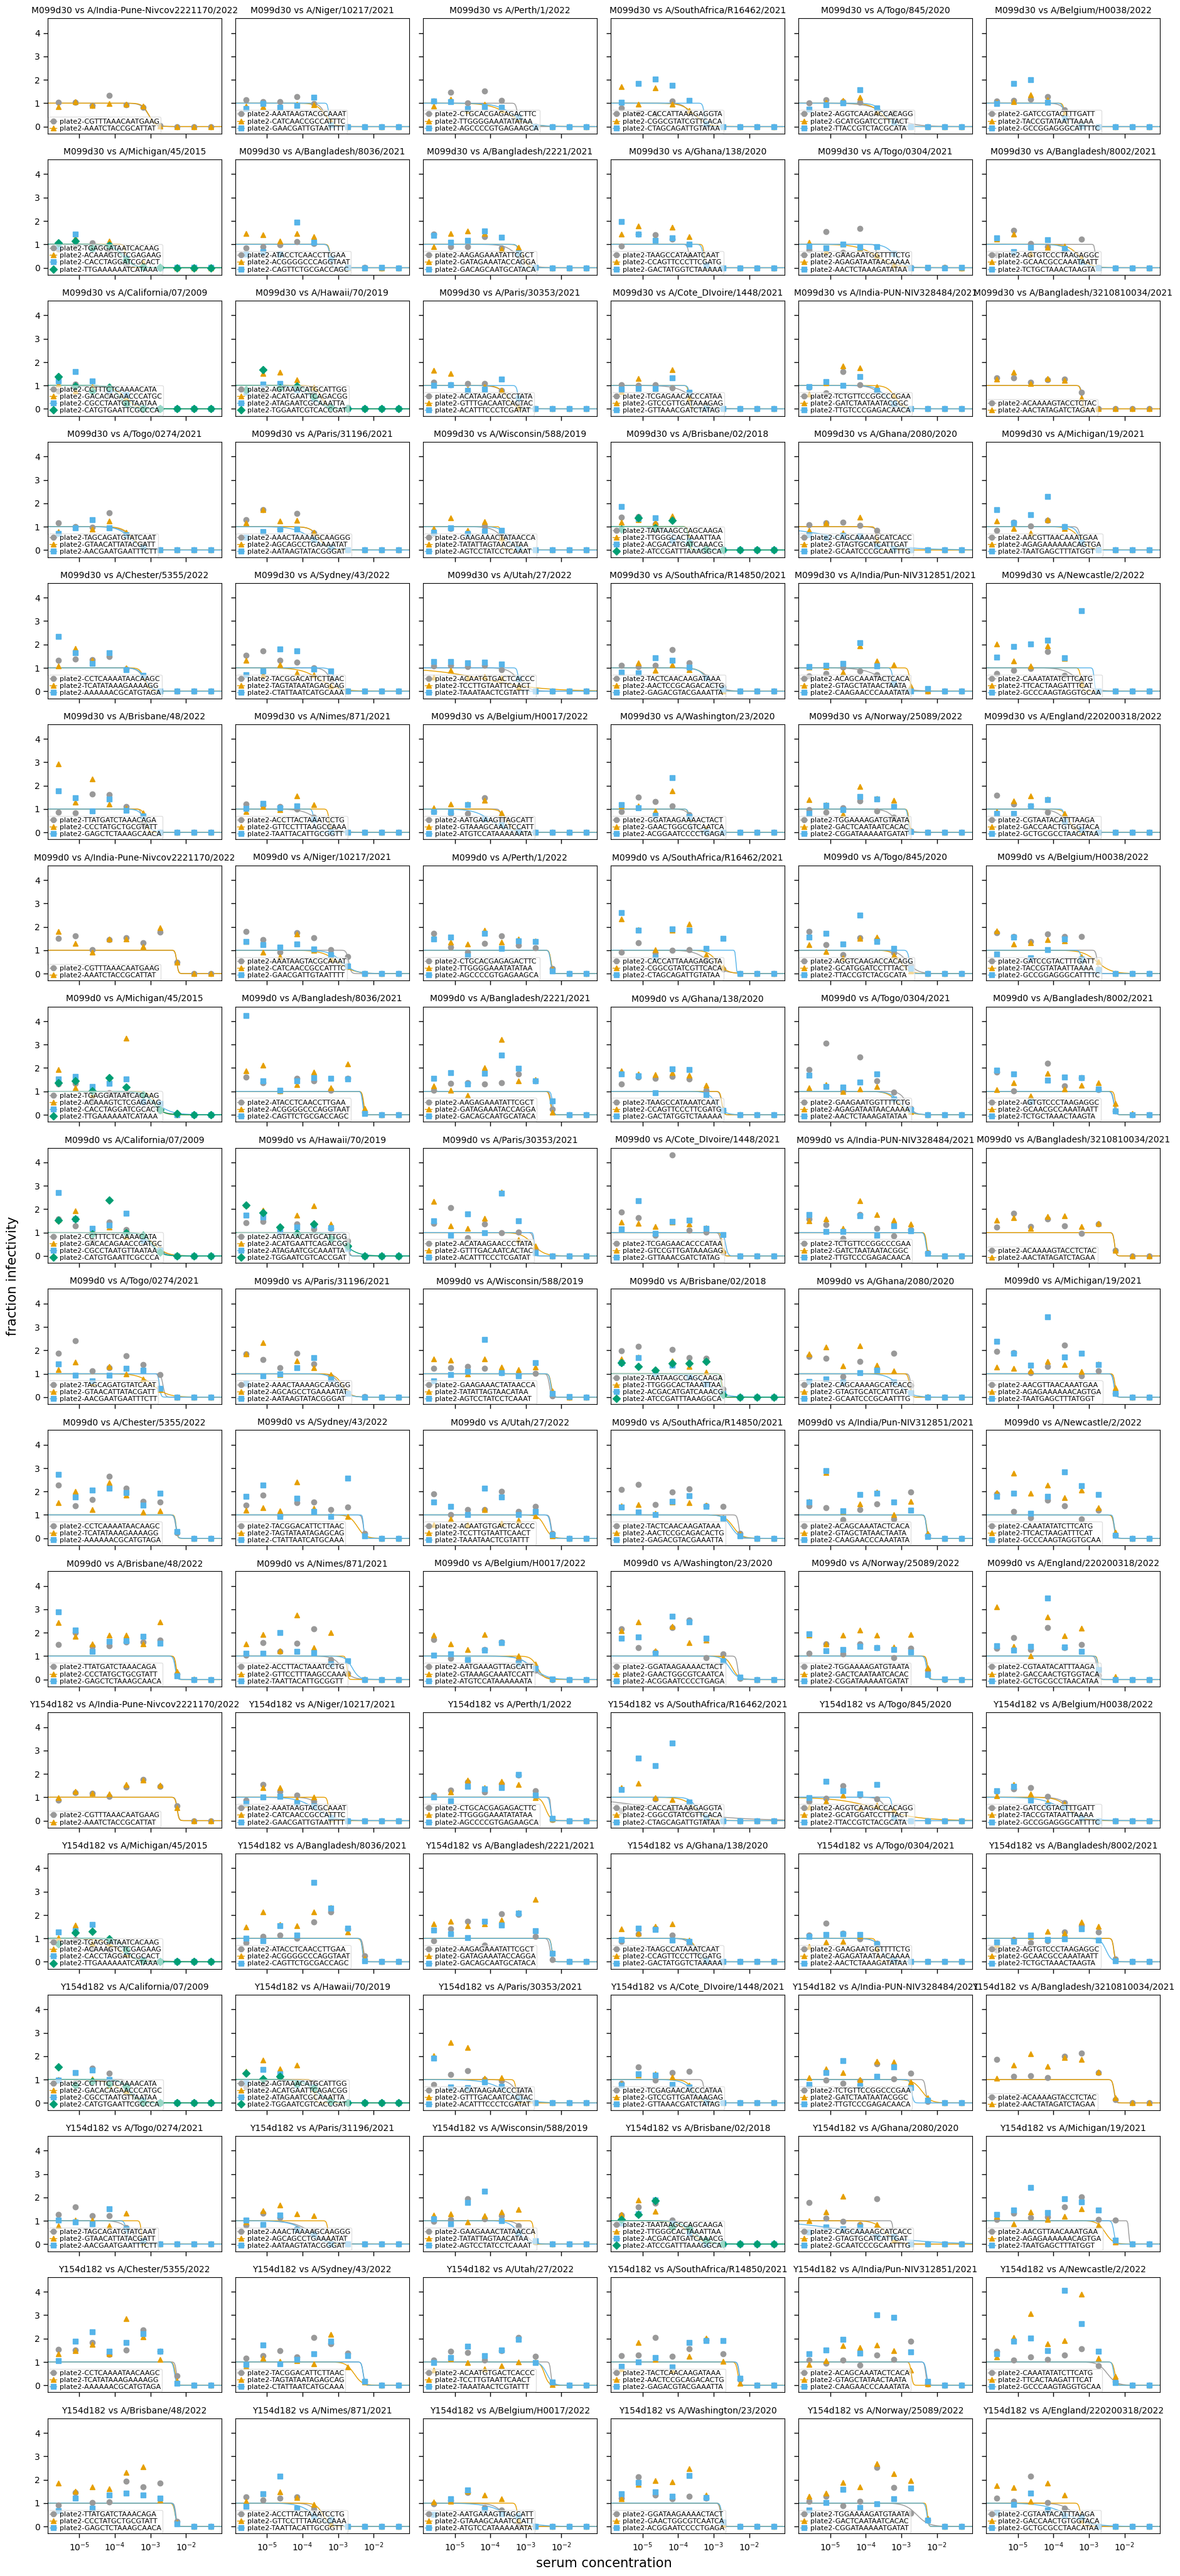

In [28]:
fits_nofilter = neutcurve.CurveFits(
    frac_infectivity.rename(
        columns={
            "frac_infectivity": "fraction infectivity",
            "concentration": "serum concentration",
        }
    ),
    conc_col="serum concentration",
    fracinf_col="fraction infectivity",
    virus_col="strain",
    serum_col="serum",
    replicate_col="plate_barcode",
)

_ = fits_nofilter.plotReplicates(
    attempt_shared_legend=False,
    legendfontsize=8,
    titlesize=10,
    ticksize=10,
    ncol=6,
)

## Save results

Write fraction infectivities to file:

In [22]:
print(f"\nWriting fraction infectivities to {frac_infectivity_csv}")
(
    frac_infectivity[
        ["serum", "strain", "plate_barcode", "dilution_factor", "frac_infectivity"]
    ]
    .sort_values(["serum", "plate_barcode", "dilution_factor"])
    .to_csv(frac_infectivity_csv, index=False, float_format="%.5g")
)


Writing fraction infectivities to results/plates/plate2/frac_infectivity.csv
